# Initialisation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import os
import sys
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab.patches import cv2_imshow

VICTIMS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/victims'
#VICTIMS_PATH = '/content/data/victims/victims'
NO_VICTIMS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/no_victims_archives'
NO_VICTIMS_PATH = '/content/data/victims/no_victims'

#CSV_PATH = '/content/drive/MyDrive/data/victims/victims-export.csv'

ARCHIVE_PATH = '/content/drive/MyDrive/data/victims/archives'
CSV_PATH = '/content/drive/MyDrive/data/victims/csv'
VICTIMS_PATH = '/content/data/victims/victims'
CSV_OUT_PATH = '/content/data/csv'

TARGET_OUTPUT_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/targets'
TARGET_OUTPUT_PATH = '/content/data/victims/targets'
UPSAMPLED_IMAGES_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/images_upsampled'
UPSAMPLED_IMAGES_PATH = '/content/data/victims/images_upsampled'
UPSAMPLED_TARGETS_PATH_ARCHIVES = '/content/drive/MyDrive/data/victims/targets_upsampled'
UPSAMPLED_TARGETS_PATH = '/content/data/victims/targets_upsampled'

MODEL_OUTPUT_PATH = '/content/drive/MyDrive/victims.tflite'

TEST_IMAGES_PATH = '/content/drive/MyDrive/data/victims/test'

os.makedirs(VICTIMS_PATH, exist_ok=True)
os.makedirs(NO_VICTIMS_PATH, exist_ok=True)
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_IMAGES_PATH, exist_ok=True)
os.makedirs(UPSAMPLED_TARGETS_PATH, exist_ok=True)
os.makedirs(CSV_OUT_PATH, exist_ok=True)

def remove_quotation_marks(x):
  return x.replace('"', '').strip()

input_height = 324
input_width = 324
INPUT_DIM = (input_width, input_height, 3)

NUM_DETECTIONS = 3
CLASS_ID_LIVING = 1.0
CLASS_ID_DEAD = 0.0
OUTPUT_DIM = (NUM_DETECTIONS, 4) # [[confidence, class id, x, y] x 3]

# Generate CSV from no victim data

In [4]:
# DO THIS FIRST!!!! LOCAL VICTIM FOLDER NEEDS TO BE EMPTY!!!
NO_VICTIMS_CSV_PATH = '/content/drive/MyDrive/data/victims/csv/no_victims.csv'
NO_VICTIMS_ARCHIVES_PATH = '/content/drive/MyDrive/data/victims/no_victim_archives'

import shutil
import zipfile

for archive in os.listdir(NO_VICTIMS_ARCHIVES_PATH):
  print(f"Unpacking {archive}...")
  with zipfile.ZipFile(NO_VICTIMS_ARCHIVES_PATH + "/" + archive) as zip_file:
    for member in zip_file.namelist():
        filename = os.path.basename(member)
        # skip directories
        if not filename:
            continue

        # copy file (taken from zipfile's extract)
        source = zip_file.open(member)
        target = open(os.path.join(VICTIMS_PATH, filename), "wb")
        with source, target:
            shutil.copyfileobj(source, target)

# Now no victim data is in final local victim data directory
# For each image create an entry in the new csv
with open(NO_VICTIMS_CSV_PATH, "w") as f:
  for filename in os.listdir(VICTIMS_PATH):
    f.write(f"{filename}, 0, 0, 0, 0, no_victim\n")

Unpacking no_victims_sa_kassel.zip...
Unpacking no_victims_bordeaux.zip...
Unpacking no_victims_bordeaux 2.zip...


# Unpack data to local runtime


In [5]:
import shutil
import zipfile

for archive in os.listdir(ARCHIVE_PATH):
  print(f"Unpacking {archive}...")
  with zipfile.ZipFile(ARCHIVE_PATH + "/" + archive) as zip_file:
    for member in zip_file.namelist():
        filename = os.path.basename(member)
        # skip directories
        if not filename:
            continue

        # copy file (taken from zipfile's extract)
        source = zip_file.open(member)
        target = open(os.path.join(VICTIMS_PATH, filename), "wb")
        with source, target:
            shutil.copyfileobj(source, target)

for csv in os.listdir(CSV_PATH):
  print(f"Copying {csv}...")
  with open(CSV_PATH + "/" + csv, "r") as f:
    f2 = open(CSV_OUT_PATH + "/" + csv, "w")
    f2.write(f.read())
    f2.close()

"""for archive in os.listdir(VICTIMS_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=VICTIMS_PATH)

for archive in os.listdir(NO_VICTIMS_PATH_ARCHIVES):
  print(f"Unpacking {archive}...")
  shutil.unpack_archive(NO_VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=NO_VICTIMS_PATH)"""

Unpacking victims3.zip...
Unpacking Kopie von daten_bordeaux.zip...
Unpacking Kopie von daten_bordeaux_2.zip...
Unpacking victims_bordeaux_vor_ort.zip...
Unpacking victims_bordeaux_2.zip...
Unpacking victims_bordeaux_007.zip...
Copying victims2-export.csv...
Copying Kopie von daten_bordeaux.csv...
Copying Kopie von daten_bordeaux_2.csv...
Copying victims_bordeuax_vor_ort.csv...
Copying victims_bordeaux_007.csv...
Copying spaß_mit_sven--export.csv...
Copying no_victims.csv...


'for archive in os.listdir(VICTIMS_PATH_ARCHIVES):\n  print(f"Unpacking {archive}...")\n  shutil.unpack_archive(VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=VICTIMS_PATH)\n\nfor archive in os.listdir(NO_VICTIMS_PATH_ARCHIVES):\n  print(f"Unpacking {archive}...")\n  shutil.unpack_archive(NO_VICTIMS_PATH_ARCHIVES + "/" + archive, extract_dir=NO_VICTIMS_PATH)'

# Generate targets

In [ ]:
target_dict = {}
images_without_victims = set() # Images that are in the csv file, but have no victims (corners)

empty_target = np.zeros(OUTPUT_DIM, dtype=np.float32)
c_nv = 0

for csv_path in os.listdir(CSV_OUT_PATH):
  if not (csv_path[-3:] == "csv"):
    continue
  with open(CSV_OUT_PATH + "/" + csv_path, "r") as f:
    for row in f.readlines()[1:]:
      cols = row.split(',')

      filename = remove_quotation_marks(cols[0])
      if not os.path.isfile(VICTIMS_PATH + "/" + filename):
        continue

      img = np.array(cv2.imread(VICTIMS_PATH + "/" + filename))
      if(not img.shape == (120, 160, 3)):
        print(f"{filename} is wrong size {img.shape}")
        continue

      label = remove_quotation_marks(cols[5])

      if(label == "no_victim"):
        cv2.imwrite(TARGET_OUTPUT_PATH + "/" + filename, empty_target)
        c_nv += 1
        continue

      if not (label == "living" or label == "dead"):
        # This label is of a corner, might have victims in it, might not
        # Save as "no_victim" target if it is not already a target
        if not filename in targets:
          images_without_victims.add(filename)
        continue

      xmin = float(cols[1])
      ymin = float(cols[2])
      xmax = float(cols[3])
      ymax = float(cols[4])
      living = label == "living"

      center_x = (xmin + xmax) / 2
      center_y = (ymin + ymax) / 2
      radius = min(xmax - xmin, ymax - ymin) / 2
      squared_radius = radius**2

      if not filename in target_dict:
        if filename in images_without_victims:
          # This image was added as "no_victims" because it contains a labelled corner
          # Remove it, as it does have victims
          images_without_victims.remove(filename)

        target_dict[filename] = np.zeros(OUTPUT_DIM, dtype=np.float32)

      id = 0
      while target_dict[filename][id][0] != 0.0:
        id += 1

      target_dict[filename][id][0] = 1.0
      if living:
        target_dict[filename][id][1] = CLASS_ID_LIVING
      else:
        target_dict[filename][id][1] = CLASS_ID_DEAD
      target_dict[filename][id][2] = center_x
      target_dict[filename][id][3] = center_y

# Train and export

Loading images and targets from /content/data/victims/images_upsampled


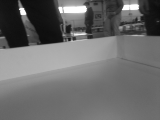

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 160, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 160, 8)       208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 20, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 20, 16)        1168      
                                                                 
 dropout (Dropout)           (None, 15, 20, 16)        0         
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                        

In [ ]:
# Load images
images = []
targets = []

print(f"Loading images from {UPSAMPLED_IMAGES_PATH}")

for filename in os.listdir(UPSAMPLED_IMAGES_PATH):
  images.append(cv2.imread(UPSAMPLED_IMAGES_PATH + "/" + filename, cv2.IMREAD_GRAYSCALE))
  targets.append(target_dict[filename])

cv2_imshow(images[15000])

images = np.array(images)
targets = np.array(targets)

batch_size = 16

# WORKING MODEL
"""
model = Sequential([
  layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
  layers.Conv2D(8, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(4),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(2),
  layers.Dropout(0.3),
  layers.Flatten(),
  #layers.Dense(1024, activation='linear'),
  layers.Dense(Ys * Xs * Cs, activation='linear'),
  layers.Reshape((Ys, Xs, Cs))
])
"""

# NEW MODEL
model = Sequential([
    layers.Rescaling(1./255, input_shape=(input_height, input_width, 1)),
    layers.Conv2D(8, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(8),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(OUTPUT_DIM, activation='linear'),
    layers.Reshape(OUTPUT_DIM)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mse', metrics=['accuracy'])

model.summary()

model.fit(images, targets, batch_size=batch_size, epochs=40, verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(MODEL_OUTPUT_PATH, 'wb') as f:
  f.write(tflite_model)

# Test

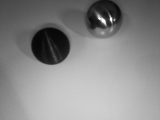

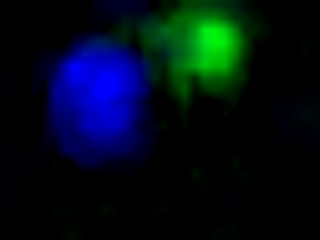

---------------------


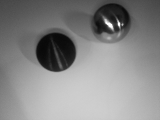

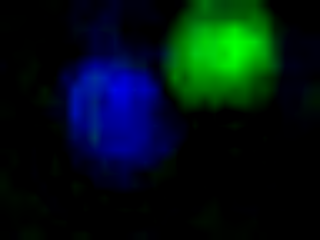

---------------------


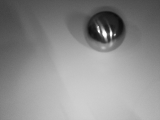

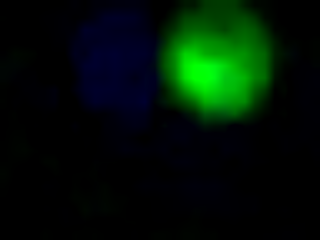

---------------------


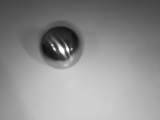

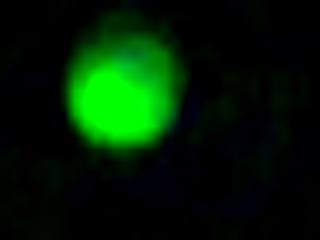

---------------------


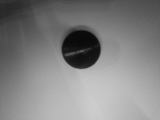

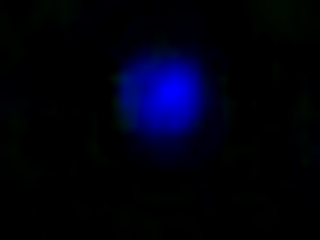

---------------------


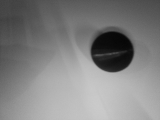

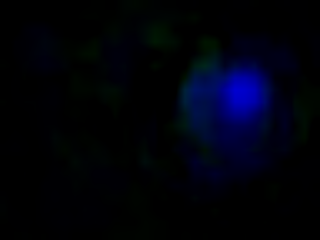

---------------------


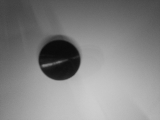

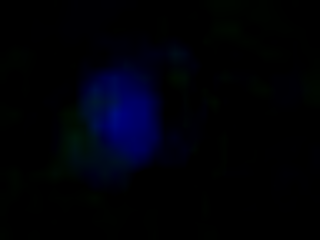

---------------------


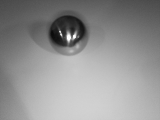

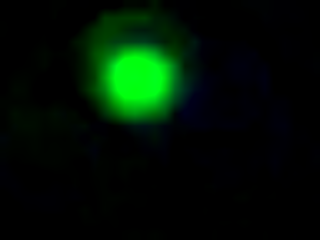

---------------------


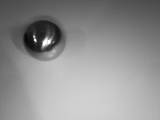

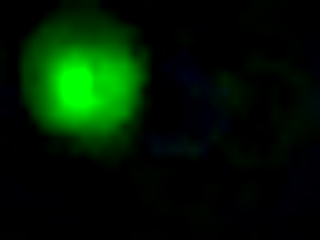

---------------------


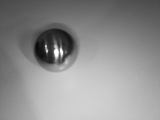

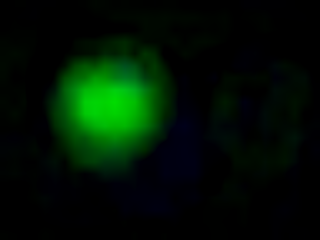

---------------------


In [ ]:
test_images = []
original_images = []
for img in os.listdir(TEST_IMAGES_PATH):
  image = cv2.imread(TEST_IMAGES_PATH + "/" + img, cv2.IMREAD_GRAYSCALE).astype(np.float32)
  #image = np.ones((120, 160), np.float32) * 255
  original_images.append(image)
  image = np.expand_dims(image, axis=0)
  image = np.expand_dims(image, axis=3)
  test_images.append(image)

interpreter = tf.lite.Interpreter(model_path=MODEL_OUTPUT_PATH)
interpreter.allocate_tensors()

output = interpreter.get_output_details()[0]
input = interpreter.get_input_details()[0]

for i, image in enumerate(test_images):
  interpreter.set_tensor(input['index'], image)
  interpreter.invoke()
  out = interpreter.get_tensor(output['index'])
  cv2_imshow(original_images[i])
  cv2_imshow(cv2.resize(np.pad(out[0,:,:,:], ((0, 0), (0, 0), (0, 1))) * 255.0, (320, 240)))
  print("---------------------")

In [ ]:
from tensorflow import keras
keras.__version__

'2.12.0'